# Notebook: 04 - Dataset EDA

**Purpose:** Exploratory Data Analysis for `urdu_stories_final_preprocessed.json` and `urdu_tokenizer_training.txt`.

Objectives: dataset counts, length distributions, special-token inventory, terminator/script checks, flagged examples, and summary preparation.

In [17]:
# Imports & helpers
import json, re, statistics
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd()
PHASE1_ROOT = NOTEBOOK_DIR
DATA_JSON = PHASE1_ROOT / 'urdu_stories_final_preprocessed.json'
if not DATA_JSON.exists():
    raise FileNotFoundError(f"{DATA_JSON} not found — run 01-cleaning.ipynb to create it")
TRAIN_TXT = PHASE1_ROOT / 'urdu_tokenizer_training.txt'

In [18]:
# Load data

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_txt_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [ln.strip() for ln in f if ln.strip()]

stories = []
tok_lines = []
if DATA_JSON.exists():
    stories = load_json(DATA_JSON)
    print(f'Loaded {len(stories)} stories from {DATA_JSON.name}')
else:
    print(f'WARNING: {DATA_JSON} not found')

if TRAIN_TXT.exists():
    tok_lines = load_txt_lines(TRAIN_TXT)
    print(f'Loaded {len(tok_lines)} lines from {TRAIN_TXT.name}')
else:
    print(f'WARNING: {TRAIN_TXT} not found')

Loaded 1780 stories from urdu_stories_final_preprocessed.json
Loaded 1669 lines from urdu_tokenizer_training.txt


In [19]:
# Basic counts & duplicates
story_count = len(stories)
titles = [s.get('urdu_title','').strip() for s in stories]
duplicate_titles = [t for t,c in Counter(titles).items() if c>1]
empty_stories = [i for i,s in enumerate(stories) if not s.get('content','').strip()]

print('story_count=', story_count)
print('duplicates=', len(duplicate_titles))
print('empty entries=', len(empty_stories))

story_count= 1780
duplicates= 73
empty entries= 0


chars: {'min': 5, 'median': 2128.5, 'mean': 2392.1960674157303, 'p90': 4322, 'max': 13742}
words: {'min': 1, 'median': 471.0, 'mean': 527.6471910112359, 'p90': 961, 'max': 3030}


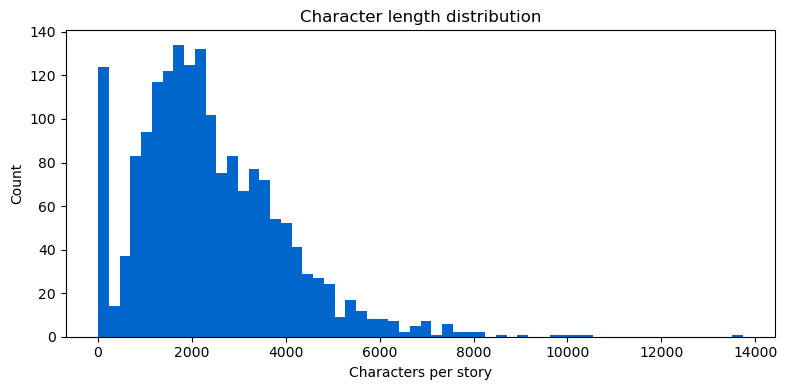

In [20]:
# Length statistics (characters & words)
char_lens = [len(s.get('content','')) for s in stories]
word_lens = [len(re.findall(r"\S+", s.get('content',''))) for s in stories]

def stats(arr):
    if not arr:
        return {'min':0,'median':0,'mean':0,'p90':0,'max':0}
    return {
        'min': min(arr),
        'median': statistics.median(arr),
        'mean': statistics.mean(arr),
        'p90': (sorted(arr)[int(0.9*len(arr))]) if len(arr)>0 else 0,
        'max': max(arr)
    }

print('chars:', stats(char_lens))
print('words:', stats(word_lens))

# histogram
plt.figure(figsize=(8,4))
plt.hist(char_lens, bins=60, color='#0066CC')
plt.xlabel('Characters per story')
plt.ylabel('Count')
plt.title('Character length distribution')
plt.tight_layout()
plt.show()

In [21]:
# Marker inventory and paragraph counts

def count_markers(text):
    return {tok: text.count(tok) for tok in ['<EOS>','<EOP>','<EOT>']}

marker_counts = [count_markers(s.get('content','')) for s in stories]
total_marker = Counter()
for mc in marker_counts:
    total_marker.update(mc)

print('Total markers (sum over stories):', dict(total_marker))
# fraction missing <EOT>
missing_eot = sum(1 for s in stories if '<EOT>' not in s.get('content',''))
print('stories missing <EOT>:', missing_eot, '/', len(stories))

# paragraphs per story (approx)
eop_counts = [mc['<EOP>'] for mc in marker_counts]
print('paragraphs per story — mean/median/max:', statistics.mean(eop_counts) if eop_counts else 0, statistics.median(eop_counts) if eop_counts else 0, max(eop_counts) if eop_counts else 0)

Total markers (sum over stories): {'<EOS>': 55010, '<EOP>': 13865, '<EOT>': 1780}
stories missing <EOT>: 0 / 1780
paragraphs per story — mean/median/max: 7.78932584269663 6.0 66


In [22]:
# Terminators and script checks

def contains_latin_or_digit(s):
    return bool(re.search(r'[A-Za-z0-9]', s))

terminator_counts = {'\u06D4':0, '\u061F':0, '.':0, '!':0, '?':0}
for s in stories:
    text = s.get('content','')
    terminator_counts['\u06D4'] += text.count('\u06D4')
    terminator_counts['\u061F'] += text.count('\u061F')
    terminator_counts['.'] += text.count('.')
    terminator_counts['!'] += text.count('!')
    terminator_counts['?'] += text.count('?')

latin_or_digit = sum(1 for s in stories if contains_latin_or_digit(s.get('content','')))
short_stories = [ (i, s.get('urdu_title',''), len(s.get('content',''))) for i,s in enumerate(stories) if len(s.get('content','').strip()) < 20 ]

print('terminator counts:', terminator_counts)
print('stories with Latin/digit chars:', latin_or_digit, '/', len(stories))
print('very short stories (<20 chars):', len(short_stories))
short_stories[:10]

terminator counts: {'۔': 53153, '؟': 878, '.': 0, '!': 1034, '?': 0}
stories with Latin/digit chars: 1780 / 1780
very short stories (<20 chars): 108


[(616, 'روزہ رکھنے کا شوق', 5),
 (1099, 'پینسل کی چوری', 5),
 (1101, 'لالچی دوست (آخری قسط)', 5),
 (1103, 'کام چور لڑکا', 5),
 (1104, 'لالچی دوست (پہلی قسط)', 5),
 (1130, 'کرائے کی لائبریری۔۔۔تحریر: مختار احمد', 5),
 (1135, 'مکّار پری (آخری قسط)تحریر: مختار احمد ', 5),
 (1137, 'انگوٹھی  اور بانسری', 5),
 (1140, 'مکّار پری (پہلی قسط)تحریر: مختار احمد', 5),
 (1150, 'بونے کے جوتے', 5)]

In [23]:
# Tokenizer-training text checks
from collections import Counter
line_lens = [len(ln) for ln in tok_lines]
print('training lines:', len(tok_lines))
print('line length stats:', stats(line_lens))

token_counter = Counter()
for ln in tok_lines:
    token_counter.update(ln.split())

top_tokens = token_counter.most_common(50)
print('Top tokens (top 20):', top_tokens[:20])



training lines: 1669
line length stats: {'min': 5, 'median': 2230, 'mean': 2548.7992810065907, 'p90': 4429, 'max': 13742}
Top tokens (top 20): [('<EOS>', 54946), ('کے', 24163), ('میں', 21833), ('کی', 19998), ('سے', 19592), ('اور', 18953), ('اس', 18357), ('نے', 16023), ('<EOP>', 13851), ('کر', 12776), ('کو', 12489), ('کا', 11385), ('وہ', 11257), ('کہ', 9993), ('ایک', 9542), ('پر', 8224), ('تو', 8183), ('بھی', 7817), ('تھا۔', 6388), ('۔', 6057)]


In [24]:
# Save concise summary
summary = {
    'story_count': len(stories),
    'duplicates': duplicate_titles,
    'empty_count': len(empty_stories),
    'char_stats': stats(char_lens),
    'word_stats': stats(word_lens),
    'marker_totals': dict(total_marker),
    'missing_eot': missing_eot,
    'terminator_counts': terminator_counts,
    'latin_or_digit_fraction': latin_or_digit / len(stories) if stories else 0,
    'short_story_count': len(short_stories)
}

print('Dataset summary:', summary)

Dataset summary: {'story_count': 1780, 'duplicates': ['ایمانداری کا انعام', 'نیکی کا صلہ', 'انعام', 'دوست وہ جو مصیبت میں کام آئے', 'چھوٹی سی نیکی', 'لالچ کا انجام', 'احساس', 'نیکی کا بدلہ', 'تربیت', 'چالاک لومڑی', 'پرانا سکہ', 'وعدہ', 'ماں کی دعا', 'صبر کا انعام', 'غرور کی سزا', 'لالچ کی سزا', 'جلد بازی کا انجام', 'کفایت شعاری', 'نیت بخیر', 'اعتماد', 'کایا پلٹ', 'زندگی کا انمول سبق', 'سچی خوشی', 'غلط فہمی', 'دوستی', 'کیمرہ', 'انوکھی ترکیب', 'غرور کا انجام', 'محنت میں عظمت ہے', 'عید کارڈ', 'سیدھا راستہ', 'لالچ بُری بلا ہے', 'جو ہوا اچھا ہوا', 'تلافی', 'بڑا کام', 'پہچان', 'صبر کا پھل', 'زندگی کا سبق', 'جذبہ', 'حسد کی سزا', 'غلطی کا احساس', 'شہزادوں کا امتحان', 'بلی کا بچہ', 'غرور کا سر نیچا', 'پچھتاوا', 'شرارت کی سزا', 'امانت', 'اتفاق میں برکت ہے', 'بڑوں کا ادب', 'ہمت والا', 'خزانے کی تلاش', 'ایمانداری کا صلہ', 'معلومات', 'اصل وجہ', 'سبق', 'ایک چیل کی کہانی', 'بلاعنوان انعامی کہانی', 'تین دوست', 'سفید کبوتری', 'مگر مچھ', 'دھوکہ', 'محنت کا جادو', 'ننھا مجاہد', 'بادشاہ اور نیک وزیر', 'بھا

## Conclusions & next steps

- Flagged issues: missing `<EOT>` in some stories, occurrences of Latin/digits, very-short stories (<20 chars).
- Run order: `01-cleaning.ipynb` → `02-segmentation-audit.ipynb` → `03-tokenizer.ipynb` → `04-dataset-eda.ipynb`.

__Action items__: regenerate tokenizer text in `03-tokenizer.ipynb` when preprocessed data changes, then rerun this EDA notebook.